# Домашнее задание 5. Линейные модели

In [69]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import TfidfTransformer
from xgboost import XGBClassifier

import scipy
from scipy import sparse

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.preprocessing import StandardScaler

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Зачитываем результат 4 домашки

In [51]:
data = np.load("files/out_4_stem_3grams.dat.npz")
users = data["users"]
features = data["features"]
#sentiments = data["sentiments"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [52]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"

df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0).sort('uid')
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0).sort('uid')
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex]).sort('uid')

/Users/vadim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/vadim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/vadim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

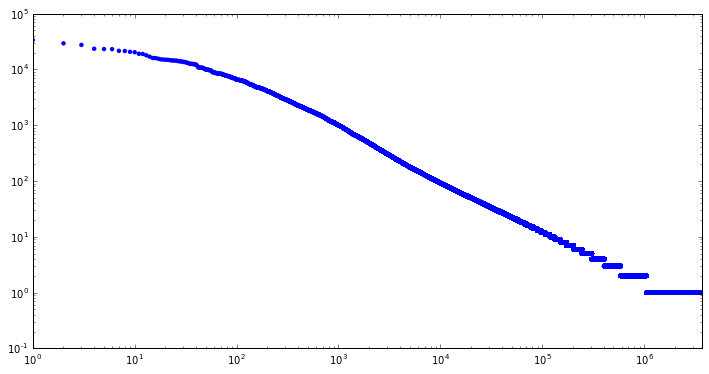

In [785]:
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    res = np.sort(x.sum(axis=0).tolist()[0])[::-1].astype(int)
    
    data = np.trim_zeros(res)
    pl.figure(figsize=(12, 6))
    pl.scatter(np.arange(len(data)), data , c='blue', edgecolors='none')
    pl.axes().set_yscale('log')
    pl.axes().set_xscale('log')
    pl.xlim((1, len(data)))
    pl.show()
    
    return res

features_counts = draw_log_hist(X_dataset)

Удаляем пустых

In [53]:
train_users = df_users_train["uid"].values
test_users  = df_users_ex['uid'].values

Y_train = df_users_train["cat"].values

train_rows = np.where(np.in1d(users, train_users))[0]
test_rows  = np.where(np.in1d(users, test_users))[0]

In [54]:
unknown = np.where(X_dataset.sum(axis=1)==0)[0]
known   = np.where(X_dataset.sum(axis=1)!=0)[0]

unknown_train = train_rows[np.in1d(train_rows, unknown)]
known_train   = train_rows[np.in1d(train_rows, known)]

unknown_test  = test_rows[np.in1d(test_rows, unknown)]
known_test    = test_rows[np.in1d(test_rows, known)]

In [55]:
X1_dataset = TfidfTransformer().fit_transform(X_dataset[known])

In [56]:
new_train_rows = np.where(np.in1d(users[known], train_users))[0]
new_test_rows  = np.where(np.in1d(users[known], test_users))[0]

In [57]:
X_train = X1_dataset[new_train_rows]
X_test  = X1_dataset[new_test_rows]
Y1_train = Y_train[np.where(X_dataset[train_rows].sum(axis=1)!=0)[0]]

In [58]:
print X_train.shape
print Y1_train.shape
print X_test.shape

(4936, 3727987)
(4936,)
(1866, 3727987)


Проведем отбор признаков.

In [59]:
selector = SelectKBest(chi2, k=1000)

X1_train = selector.fit_transform(X_train, Y1_train)
X1_test  = selector.transform(X_test)

In [60]:
print selector.transform(features)

[[u'#2015strokecong' u'#2016elect #tcot' u'#26dem' u'#26dem #wadem'
  u'#4profit' u'#603forhrc' u'#99countymeet' u'#abetterway' u'#abt'
  u'#adcon22' u'#adv9' u'#alaskanbushpeopl' u'#alpolit'
  u'#alpolit #teammarco' u'#alwaystrump' u'#alwaystrump #trump2016'
  u'#americanidol' u'#americanidol #idol' u'#amp' u'#apa16'
  u'#apologizeforwhat' u'#apopka' u'#ar3' u'#arbsay' u'#arprep' u'#atheism'
  u'#ayearwithh' u'#azcr' u'#azelectionfraud' u'#b1g #b1g' u'#baylor'
  u'#bayridg' u'#bb17' u'#bc2dc16' u'#bcleg' u'#bcleg #bcpoli' u'#bcpoli'
  u'#beatdemocrat' u'#bencarsonfact' u'#bencarsonfact #bencarsonwikipedia'
  u'#bencarsonwikipedia' u'#berni' u'#berni #berniesand'
  u'#berni #feelthebern' u'#bernie2016' u'#bernie2016 #bernieorbust'
  u'#bernie2016 #berniesand' u'#bernie2016 #berniestrong'
  u'#bernie2016 #birdiesand' u'#bernie2016 #debatewithberni'
  u'#bernie2016 #demdeb' u'#bernie2016 #feelthebern'
  u'#bernie2016 #philly4berni' u'#bernie2016 #stillsand'
  u'#bernie2016 berni' u'#bern

/Users/vadim/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Вариант задания генерируется на основании вашего ника в техносфере.

In [61]:
USER_NAME = "va.navrajnih"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L1 regularization optimized by stochastic gradient descent


Реализуем выбранный алгоритм

In [84]:
class LogisticRegression():
    
    def __init__(self, C=0.01, gb_step=0.001, eps=0.01, max_iter=10000):
        self.C = C
        self.gb_step = gb_step
        self.eps = eps
        self.max_iter = max_iter
        
        self.last5  = np.array([np.inf]*5)
        
        self.n_features = 0
        self.n_samples = 0
        
    def eta(self, k):
        return self.gb_step
        
    def sigma(self, x):
        return (1 / (1 + np.exp(-np.dot(self.w.reshape(1,-1), x)))).reshape(-1, 1)
        
    def grad(self):
        return np.sum([(self.sigma(x.reshape(-1, 1)) - self.Y[i])*x.reshape(-1, 1) for i, x in enumerate(self.X)])
    
    def regulator(self):
        return np.sign(self.w) #L1 regularization
    
    def stoch_grad(self): #Stochastic Gradient Descent
        idx = np.random.randint(0, self.n_samples)
        x = self.X[idx]
        return (self.sigma(x.reshape(-1, 1)) - self.Y[idx])*x.reshape(-1, 1)

    def fit(self, X, Y=None):
        if self.n_samples == 0:
            self.X = X.toarray()
            self.Y = Y.reshape(-1, 1)
            self.n_features = X.shape[1]
            self.n_samples = X.shape[0]
            self.w = np.random.normal(loc=0, scale=0.01, size=self.n_features).reshape(-1, 1)
        else:
            self.X = np.concatenate((self.X, X.toarray()), axis=0)
            self.Y = np.concatenate((self.Y, Y.reshape(-1, 1)), axis=0)
            self.n_samples = X.shape[0]
            
        for k in xrange(self.max_iter):
            dJ = self.stoch_grad()
            self.last5[k%5] = np.linalg.norm(dJ)
            self.w -= self.eta(k) * dJ + self.C * self.regulator()
            
            if self.eta(k)*self.last5.mean() < self.eps:
                break

    def predict_proba(self, X):
        if self.n_samples == 0:
            raise BaseException("You should firstly fit the data")

        return self.sigma(X.toarray().T)

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [89]:
C = [0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X, Y):
    results = []

    for c in C:
        kf = KFold(X.shape[0], n_folds=5)
        tmp = []
        for train, test in kf:
            cls = LogisticRegression(eps=0., gb_step=0.001, C=c, max_iter=10000)
            cls.fit(X[train], Y[train])
            tmp.append(roc_auc_score(Y[test], cls.predict_proba(X[test])))
            
        results.append(np.mean(tmp))
    
    return results.index(max(results))

index = select_reg_parameter(C, X1_train, Y1_train)
print index

2


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

Area under the ROC curve : 0.684989


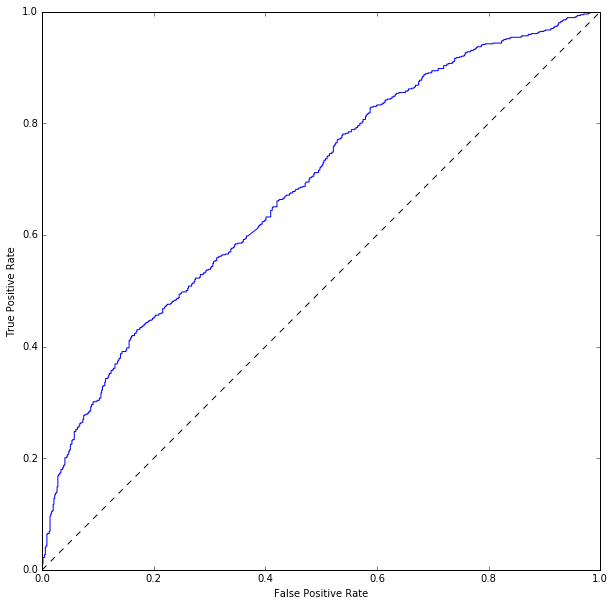

In [90]:
def classify(X, Y, test_size, C):  
    cls = LogisticRegression(eps=0., gb_step=0.001, C=C, max_iter=10000)
    test_cnt  = int(X.shape[0] * test_size)

    cls.fit(X[:-test_cnt], Y[:-test_cnt])
    predictions = cls.predict_proba(X[-test_cnt:])
    fpr, tpr, thr = roc_curve(Y[-test_cnt:], predictions)
    roc_auc = roc_auc_score(Y[-test_cnt:], predictions)
    return tpr, fpr, roc_auc

tpr, fpr, roc_auc = classify(X1_train, Y1_train, 0.3, C[index])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    pl.figure(figsize=(10, 10))
    pl.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.

In [86]:
cls = LogisticRegression(eps=0., gb_step=0.001, C=C[index], max_iter=10000)
cls.fit(X1_train, Y1_train)
predictions = cls.predict_proba(X1_test)

In [68]:
with open('results.txt', 'w') as f:
    f.write('uid,cat\n')
    
    for user, res in zip(users[known_test], predictions):
        f.write('%d,%f\n' % (user, res))
        
    for user in users[unknown_test]:
        f.write('%d,%f\n' % (user, 0.5))